In [1]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import cv2
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

In [2]:
#Fucntion to plot the images in two sub-plots
def plt_images(img_1, title_1, img_2, title_2, cmap='gray'):
    # Visualize undirstorsion
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    ax1.imshow(img_1)
    ax1.set_title(title_1, fontsize=50)
    ax2.imshow(img_2, cmap='gray')
    ax2.set_title(title_2, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [3]:
# Computing camea calibration and distortion of images in this step

In [4]:
nx = 9
ny = 6

objp = np.zeros((ny*nx,3),np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2) 

objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane

images = glob.glob('camera_cal/calibration*.jpg') #Reads the array od images from the folder

for i, fname in enumerate(images):
    
    #read the each image from the array
    img = cv2.imread(fname)
    
    #convert to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, add object points, image points
    if ret == True:
       
        objpoints.append(objp) #append the object points
        imgpoints.append(corners) #append the found corners as image points

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        
        #calibrate camera
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[1::-1], None, None)
        
        #store the undistorted and calibrated camera images to output folder
        cv2.imwrite('output_images/chessboard/calibrated/calibration%0i.jpg' %(int(i+1)), img)

In [5]:
#Applying distortion for the raw images of chessboard

In [6]:
raw_images = glob.glob('camera_cal/calibration*.jpg')

for i, name in enumerate(raw_images):
        
    #read the each image from the array
    img = cv2.imread(name)
    
    #removing distortion of image"
    undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)
    
    #store the undistorted images to output folder
    cv2.imwrite('output_images/chessboard/undist/calibration%0i_undist.jpg' %(int(i+1)), undistorted_img)   

In [7]:
#Applying distortion for the raw images of test images

In [8]:
raw_test_images = glob.glob('test_images/*.jpg')

for i, name in enumerate(raw_test_images):
        
    #read the each image from the array
    img = cv2.imread(name)
    
    undistorted_rawimg = cv2.undistort(img, mtx, dist, None, mtx)
    
    #store the undistorted images to output folder
    cv2.imwrite('output_images/undist/test%0i.jpg' %(int(i+1)), undistorted_rawimg)

In [9]:
#color transforms, gradients, etc., to create a thresholded binary image

In [10]:
#In this block, a signale color is passed to sobel() function. hence, it should be converted to gray scale. (Undistorted raw images are used)
def abs_sobel_thresh(colimg, orient='x', thresh=(0, 255), sobel_kernel = 3):
    
        gray = cv2.cvtColor(colimg, cv2.COLOR_RGB2GRAY) # convert the undistored image to gray
                  
        if orient == 'x':       #magnitude in the x-direction
            
            abs_Sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, sobel_kernel))
            
        if orient == 'y':       #magnitude in the y-direction
            
            abs_Sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, sobel_kernel))
                        
        # Rescale back to 8 bit integer
        scaled_sobel = np.uint8(255*abs_Sobel/np.max(abs_Sobel))
    
        binary = np.zeros_like(scaled_sobel) # assign the binary values to zero
        
        binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1 # when the condition is met then replace the zeros with 1
               
        return binary
        

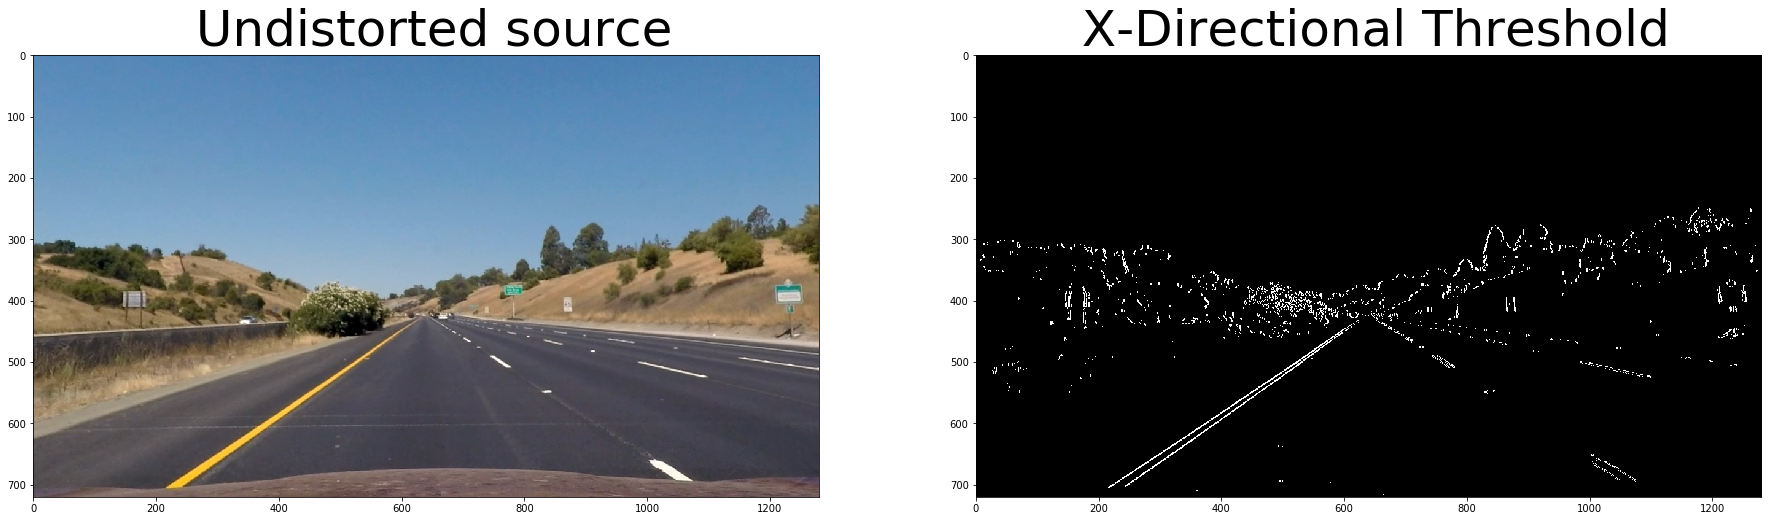

In [11]:
img = mpimg.imread('output_images/undist/test1.jpg')
gradx = abs_sobel_thresh(img, orient='x', thresh=(40, 100), sobel_kernel = 15)
plt_images(img,' Undistorted source', gradx, ' X-Directional Threshold')

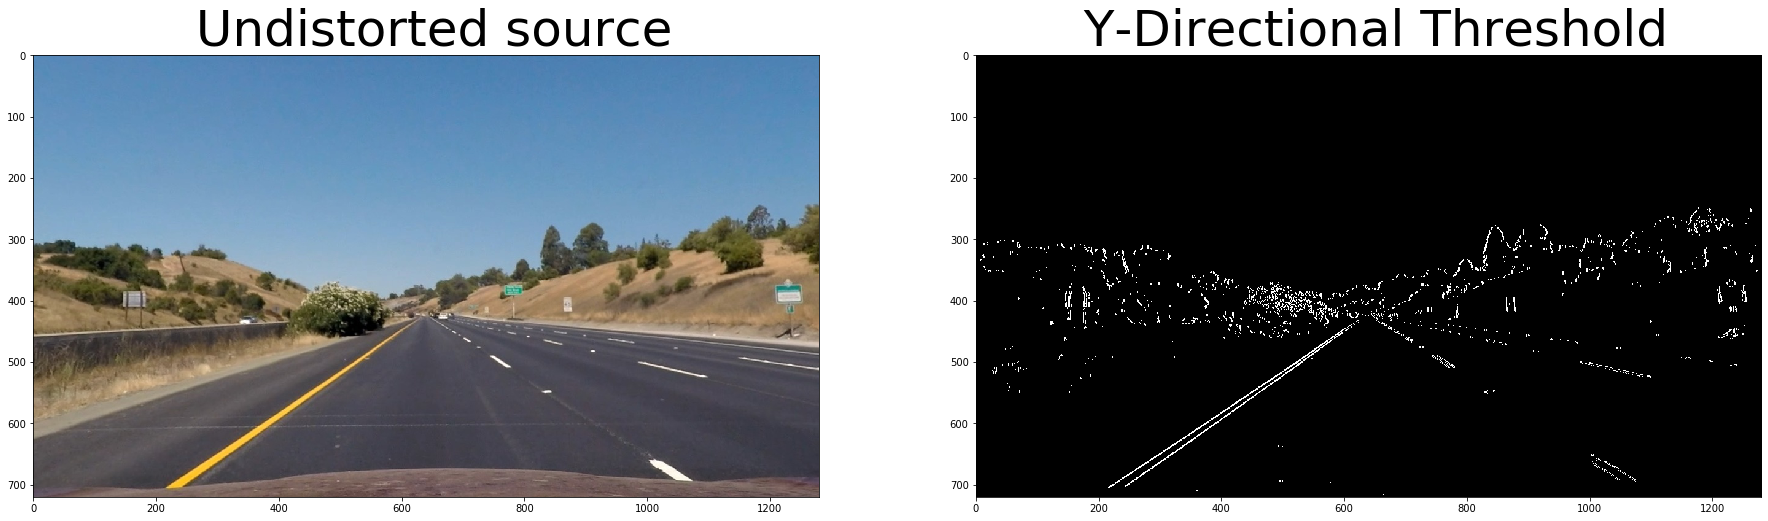

In [12]:
img = mpimg.imread('output_images/undist/test1.jpg')
grady = abs_sobel_thresh(img, orient='y', thresh=(40, 100), sobel_kernel = 15)
plt_images(img,' Undistorted source', gradx, ' Y-Directional Threshold')

In [13]:
def mag_thresh(mimage, sobel_kernel=3, mag_thresh=(0, 255)):
    
        # Calculate gradient magnitude   
        gray = cv2.cvtColor(mimage, cv2.COLOR_RGB2GRAY) # convert the undistored image to gray
                  
        #magnitude in the x-direction            
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, sobel_kernel)
            
        #magnitude in the y-direction
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, sobel_kernel)
        
         # Calculate the gradient magnitude
        gradmag = np.sqrt(sobelx**2 + sobely**2)
        
        # Rescale to 8 bit
        scale_factor = np.max(gradmag)/255 
        
        gradmag = (gradmag/scale_factor).astype(np.uint8) 
        
        # Create a binary image of ones where threshold is met, zeros otherwise
        mag_binary = np.zeros_like(gradmag)
        
        mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
        
        # Apply threshold
        return mag_binary

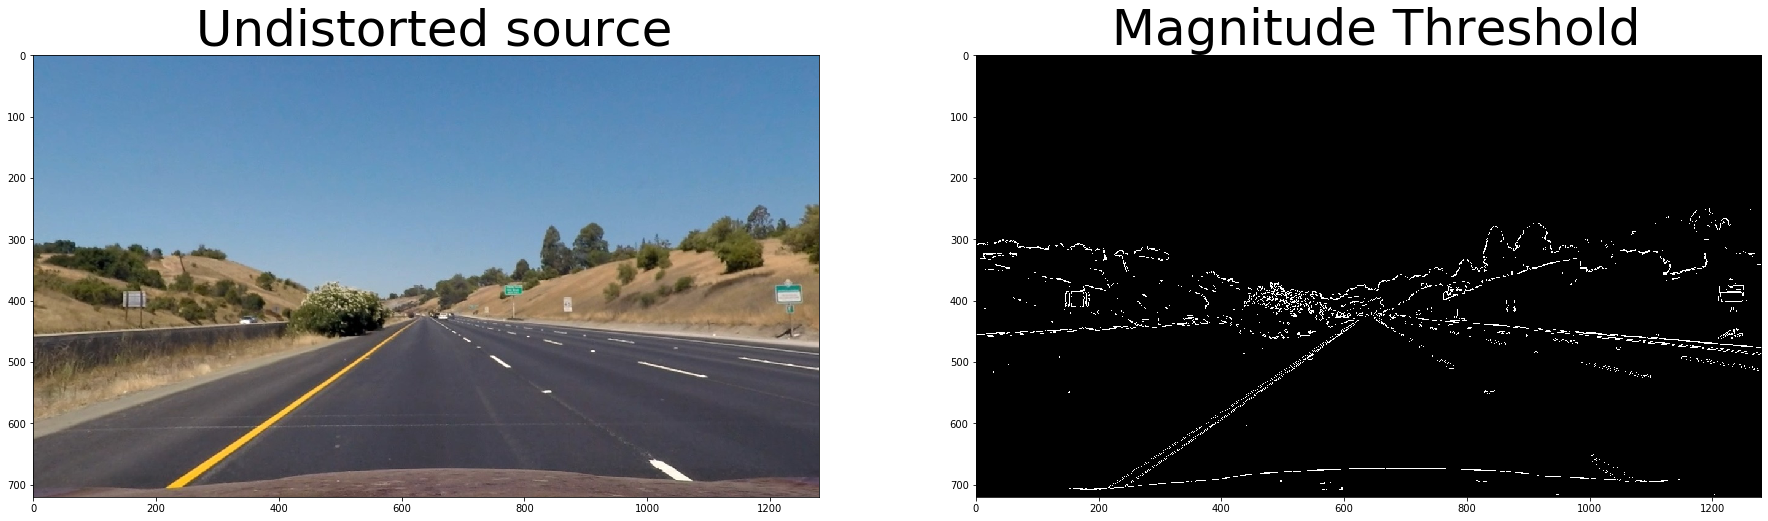

In [14]:
img = mpimg.imread('output_images/undist/test1.jpg')
mag = mag_thresh(img, sobel_kernel = 15, mag_thresh =(60, 100))
plt_images(img,' Undistorted source', mag, ' Magnitude Threshold')

In [15]:
def dir_threshold(mimage, sobel_kernel=9, dir_thresh=(0, np.pi/2)):

    gray = cv2.cvtColor(mimage, cv2.COLOR_RGB2GRAY) # convert the undistored image to gray
                  
    #magnitude in the x-direction            
    abs_sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel))
            
    #magnitude in the y-direction
    abs_sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel))
        
    # Calculate gradient direction
    graddir = np.arctan2(abs_sobely,abs_sobelx)
    
    # Apply threshold
    dir_binary = np.zeros_like(graddir)
    
    dir_binary[(graddir >= dir_thresh[0]) & (graddir <= dir_thresh[1])] = 1
    
    
    return dir_binary

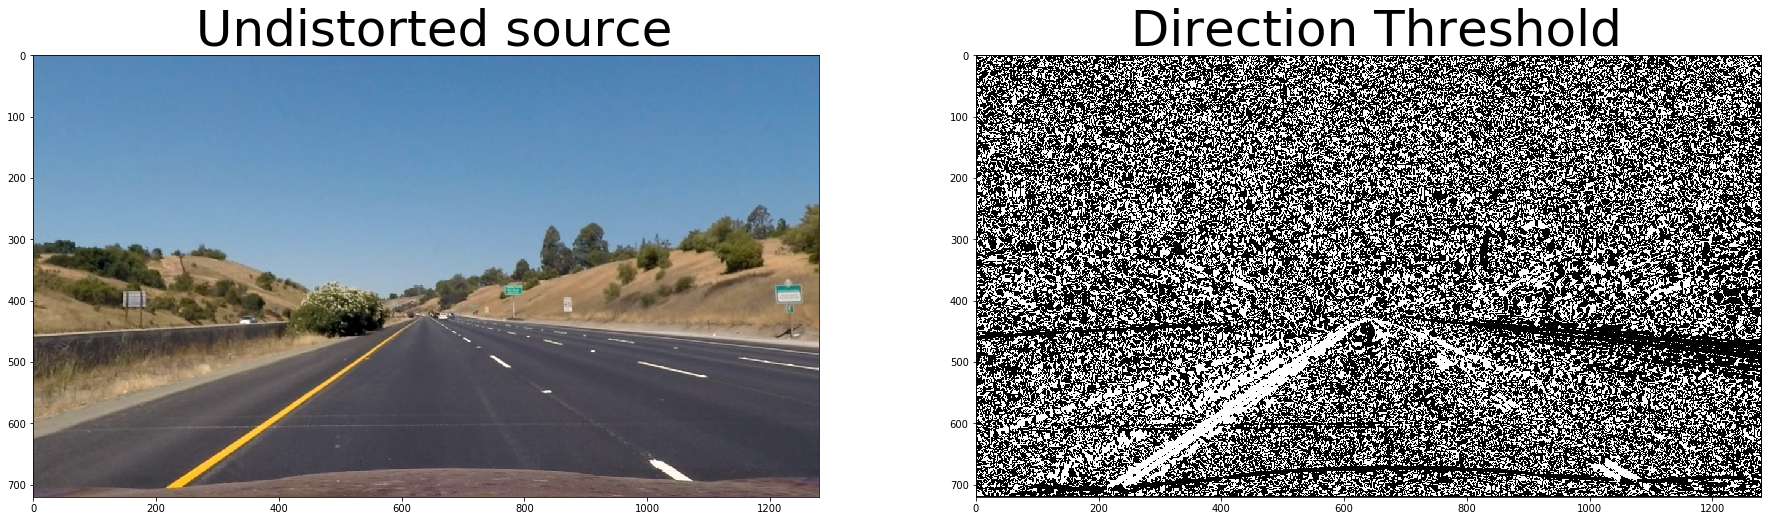

In [16]:
img = mpimg.imread('output_images/undist/test1.jpg')
gradir = dir_threshold(img, sobel_kernel = 15, dir_thresh=(0.7,1.3))
plt_images(img,' Undistorted source', gradir, ' Direction Threshold')

In [17]:
#define color transformations

In [18]:
def color_RGBtransform(img, thresh):
    
    #create binary output using R channel
    R = img[:,:,0]    
    r_binary = np.zeros_like(R)
    r_binary[(R > thresh[0]) & (R <= thresh[1])] = 1
    
    return r_binary      

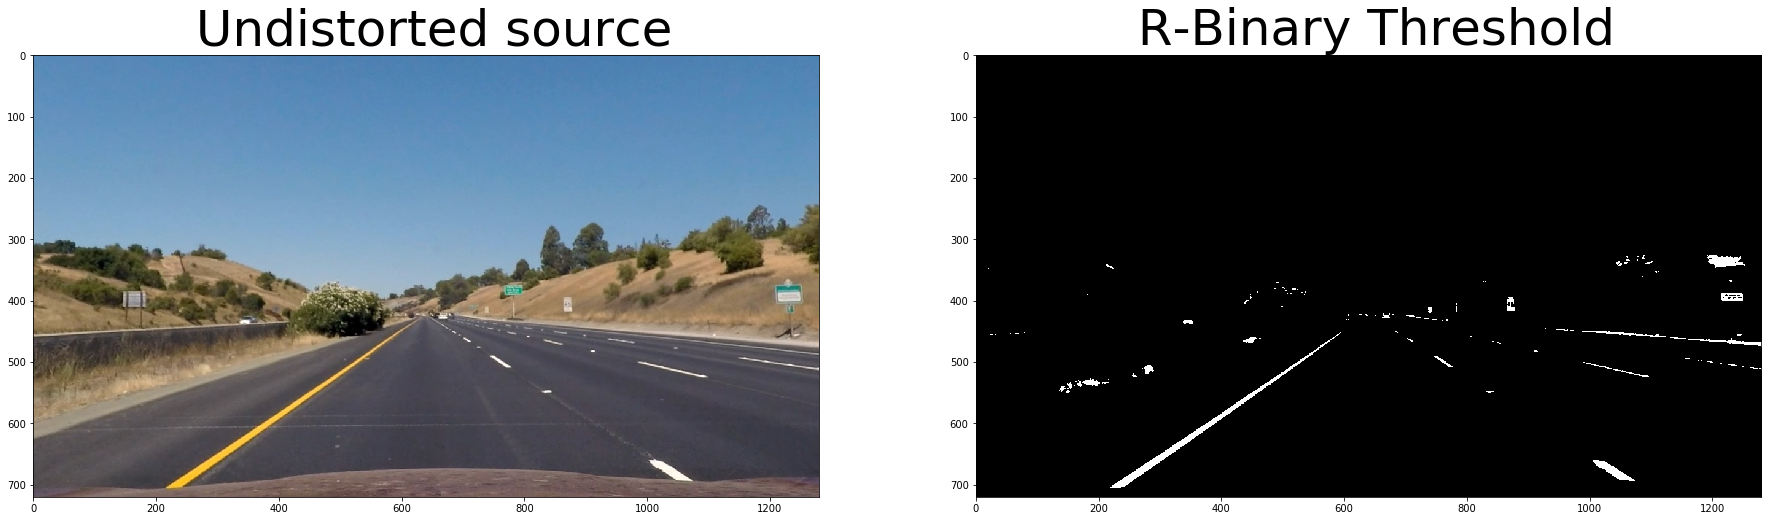

In [19]:
img = mpimg.imread('output_images/undist/test1.jpg')
rbin = color_RGBtransform(img, thresh=(200, 255))
plt_images(img,' Undistorted source', rbin, ' R-Binary Threshold')

In [20]:
def color_HLStransform(img, s_thresh):  
    
    ls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS) # convert the RGB image to HLS
    
    #create binary output using s channel
    S = ls[:,:,2]   
    s_binary = np.zeros_like(S)
    s_binary[(S > s_thresh[0]) & (S <= s_thresh[1])] = 1
    
    return s_binary  

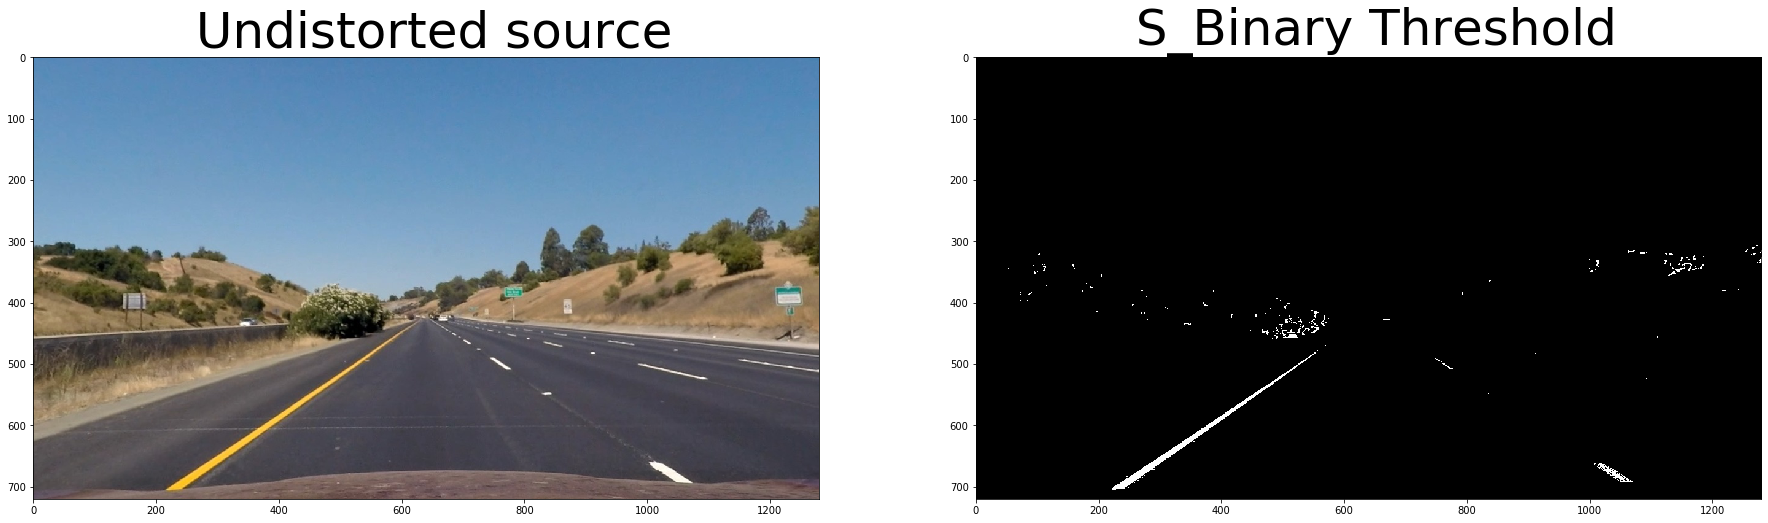

In [21]:
img = mpimg.imread('output_images/undist/test1.jpg')
sbin = color_HLStransform(img, s_thresh=(190, 255))
plt_images(img,' Undistorted source', sbin, ' S_Binary Threshold')

In [22]:
def combined_thresh(gradx, grady, mag, gradir, s_binary, r_binary, sobel_kernel = 9):
    
    combined = np.zeros_like(s_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag == 1) & (gradir == 1)) & (s_binary ==1) & (r_binary ==1)] = 1
    
    return combined

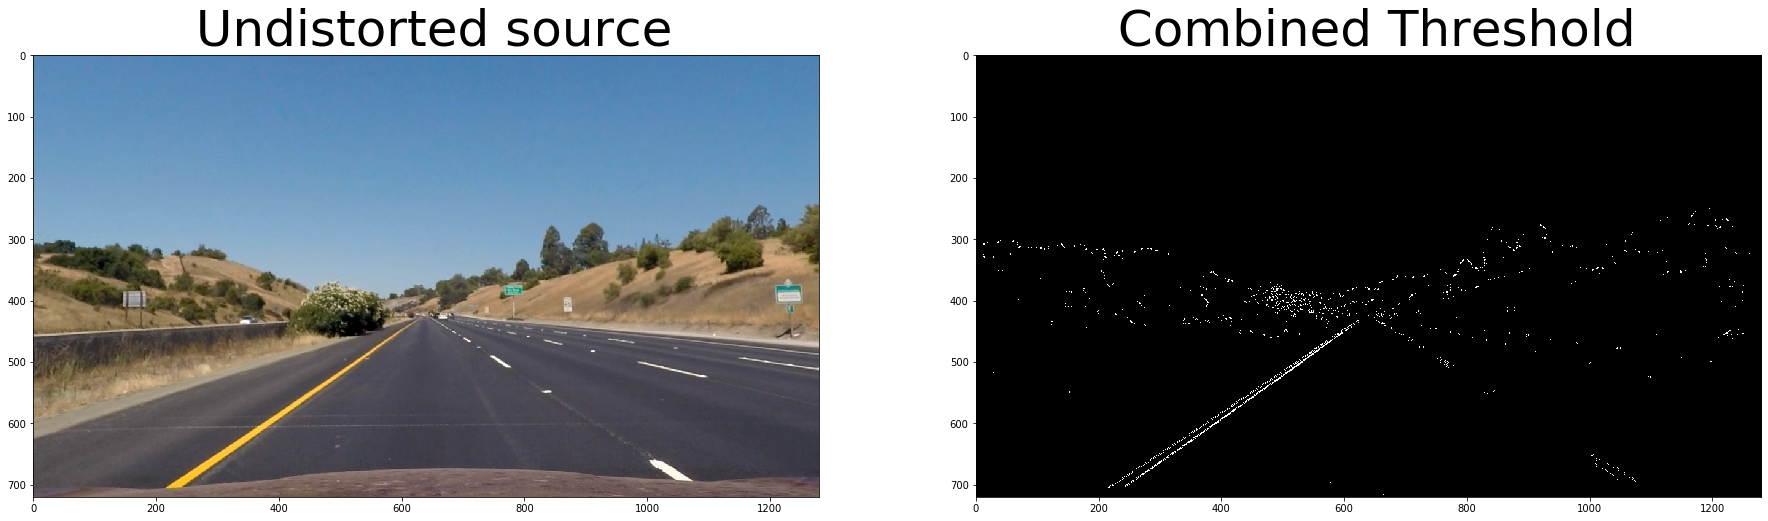

In [23]:
combin = combined_thresh(gradx, grady, mag, gradir, sbin, rbin, sobel_kernel = 15)
plt_images(img,' Undistorted source', combin, ' Combined Threshold')

In [24]:
# A single fucntion is written to make the job easier to process all the binary outputs of gradient, threshold, color.

def process_images(img): 
    
    gradx = abs_sobel_thresh(img, orient='x', thresh=(40, 100), sobel_kernel = 15)
    
    grady = abs_sobel_thresh(img, orient='y', thresh=(40, 100), sobel_kernel = 15)
    
    mag = mag_thresh(img, sobel_kernel = 15, mag_thresh=(60, 100))
    
    gradir = dir_threshold(img, sobel_kernel = 15, dir_thresh=(0.7, 1.3))
        
    r_binary = color_RGBtransform(img,thresh=(195,255))
    
    s_binary = color_HLStransform(img, s_thresh=(190, 255))
        
    combined_binary = combined_thresh(gradx, grady, mag, gradir, s_binary, r_binary, sobel_kernel=15)
                           
    return gradx, grady, mag, r_binary, gradir, s_binary, r_binary, combined_binary
   

In [25]:
img_files=  glob.glob('output_images/undist/test*.jpg')

for i, name in enumerate(img_files):
        
    #read the each image from the array
    img = mpimg.imread(name)       

    gradx, grady, mag, gradir, r_binary, s_binary, r_binary, combined_binary = process_images(img)
    
    plt_images(img, 'Distored source Image%i' %(int(i+1)), gradx, ' X -Threshold Gradient   %i'%(int(i+1)))
    plt.savefig('output_images/thresh_img/test%0i_gradx.jpg'%(int(i+1)))
    plt.close()
    plt_images(img, 'Distored source Image %i' %(int(i+1)), grady, ' Y -Threshold Gradient %i' %(int(i+1)))
    plt.savefig('output_images/thresh_img/test%0i_grady.jpg'%(int(i+1)))
    plt.close()
    plt_images(img, 'Distored source Image %i ' %(int(i+1)), mag, 'Magnitude Threshold %i'  %(int(i+1)))
    plt.savefig('output_images/thresh_img/test%0i_magt.jpg'%(int(i+1)))
    plt.close()
    plt_images(img, 'Distored source Image %i'  %(int(i+1)), gradir, 'Direction Threshold %i' %(int(i+1)))
    plt.savefig('output_images/thresh_img/test%0i_dir.jpg'%(int(i+1)))
    plt.close()
    plt_images(img, 'Distored source Image %i' %(int(i+1)), r_binary, 'Threshold for Red in RGB transform %i' %(int(i+1)))
    plt.savefig('output_images/thresh_img/test%0i_rbint.jpg'%(int(i+1)))
    plt.close()
    plt_images(img, 'Distored source Image %i' %(int(i+1)), s_binary, 'S Threshold for HLS transform %i' %(int(i+1)))
    plt.savefig('output_images/thresh_img/test%0i_sbint.jpg'%(int(i+1)))
    plt.close()
    plt_images(img, 'Distored source Image %i' %(int(i+1)), combined_binary, 'Combined S and Gradient threshold %i' %(int(i+1)))
    plt.savefig('output_images/thresh_img/test%0i_combin.jpg'%(int(i+1)))
    plt.close()

In [26]:
def per_transform(image):
    
    # Grab the image shape
    img_size = (image.shape[1], image.shape[0])

    #source co-oridnates for the perspective tarnsform
    src = np.float32(
            [[286,  700],  # Bottom left
             [599,  477],  # Top left
             [725,  477],  # Top right
             [1125, 700]]) # Bottom right
    
    #destination co-oridnates for the perspective tarnsform
    dst = np.float32([[275,  720],  # Bottom left
             [275,    0],  # Top left
             [1065,   0],  # Top right
             [1065, 720]]) # Bottom right
    

    #With the described src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    #inverse perspective trasnform
    InvM = cv2.getPerspectiveTransform(dst, src)
    
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(image, M, img_size)

    return warped, M, src, dst, InvM       

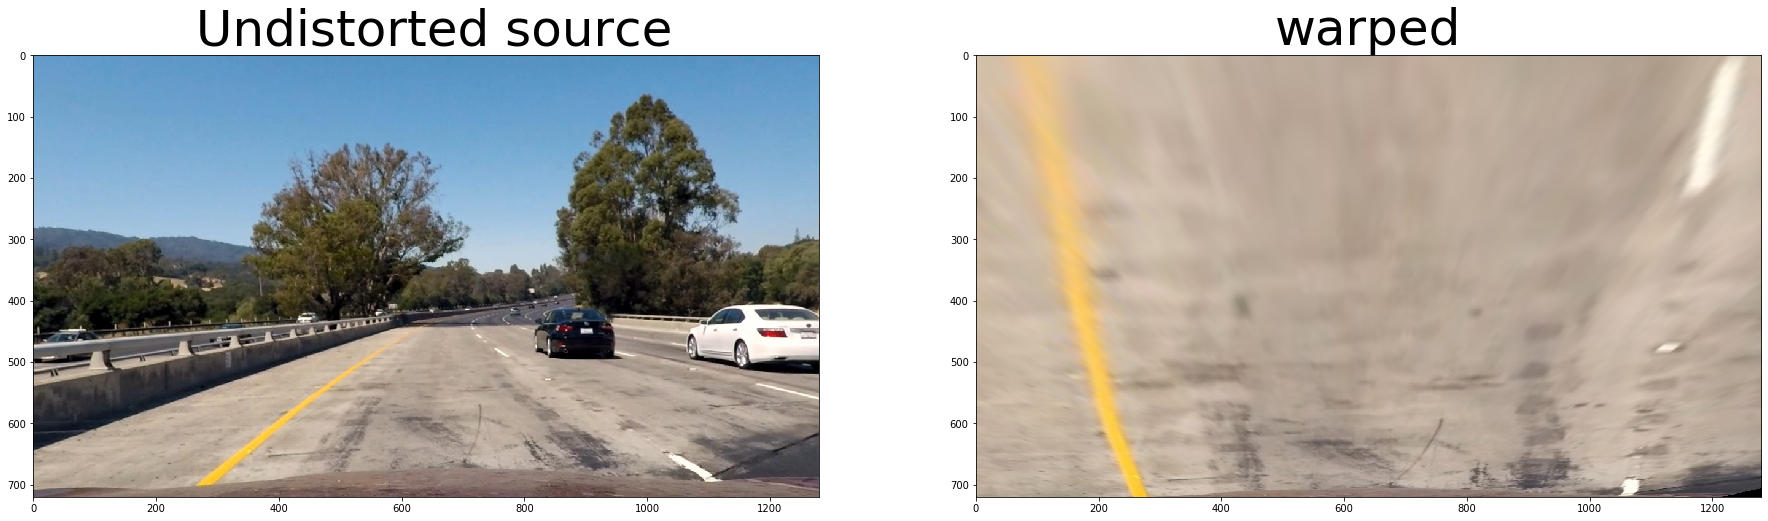

In [27]:
img = mpimg.imread('output_images/undist/test3.jpg')
warped, M, src, dst, InvM  = per_transform(img)
plt_images(img,' Undistorted source', warped, 'warped')
plt.savefig('output_images/perspective_transform.jpg')

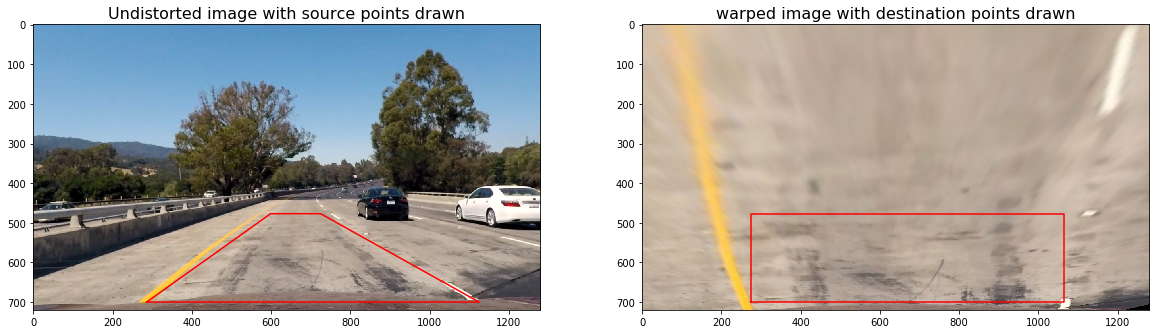

In [28]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Undistorted image with source points drawn', fontsize=16)
ax1.plot(Polygon(src).get_xy()[:, 0], Polygon(src).get_xy()[:, 1], color='red')
ax1.imshow(img)

ax2.set_title('warped image with destination points drawn', fontsize=16)
ax2.plot(Polygon(dst).get_xy()[:, 0], Polygon(src).get_xy()[:, 1], color='red')
ax2.imshow(warped)

In [29]:
images=  glob.glob('output_images/undist/test*.jpg')

for i, name in enumerate(images):
    
    #read the each image from the array
    img = mpimg.imread(name)       

    warped, M, src, dst, InvM  = per_transform(img)
    plt_images(img,' Undistorted source%i' %(int(i+1)), warped, 'warped%i' %(int(i+1)))
    plt.savefig('output_images/perspective_transform%i.jpg' %int(i+1))
    plt.close()
    

In [30]:
#defining histogram
def hist(img):
    
    bottom_half = img[img.shape[0]//2:,:]
    
    histogram = np.sum(bottom_half, axis=0)
    
    # Find the peak of the left and right halves of the histogram
    
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    
    leftx_base = np.argmax(histogram[:midpoint])
    
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    return histogram, leftx_base, rightx_base

In [31]:
def lines(binary_warped):
    
    # Take a histogram of the bottom half of the image
    histogram, leftx_base, rightx_base = hist(binary_warped)  
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    
    # Set the width of the windows +/- margin
    margin = 100
    
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

In [32]:
def fit_polynomial(binary_warped):
    
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img  = lines(binary_warped)
    
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

    #Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
            
    return out_img, left_fit, right_fit, left_fitx, ploty, right_fitx, ploty

In [33]:
def detect_similar_lines(binary_warped, left_fit, right_fit):
     
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    margin = 100
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # If any of the lines could not be found, 
    # perform a more exhaustive search
    if (leftx.size == 0 or rightx.size == 0):
        return lines(binary_warped)
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
        
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    # Color in left and right line pixels
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
     
    for index in range(binary_warped.shape[0]):
        
        cv2.circle(out_img, (int(left_fitx[index]), int(ploty[index])), 3, (255,255,0))
        cv2.circle(out_img, (int(right_fitx[index]), int(ploty[index])), 3, (255,255,0))
    
    return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty), out_img.astype(int)
    
    return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty), out_img

In [34]:
def curvature_radius (leftx, rightx, binary_warped, xm_per_pix=3.7/700, ym_per_pix = 30/720):
    
    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    
    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
    
    # Fit new polynomials to x,y in world space
    y_eval = np.max(ploty)
    
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radius of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Now our radius of curvature is in meters
    return left_curverad, right_curverad

In [35]:
def car_pos(img, leftx, rightx, xm_per_pix):
    
    mid = img.shape[1]/2
    
    # Car position with respect to the lane
    car_pos = (leftx[-1] + rightx[-1])/2
    
    #offset
    car_offset = np.float32((mid - car_pos) * xm_per_pix)

    return car_offset


In [36]:
def lane(img, warped, left_fitx, right_fitx, ploty, Minv, left_curverad, right_curverad, Veh_pos):
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
     
    #cv2.putText(newwarp, 'Left lane line curvature is {:.2f} m'.format(left_curverad), (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    
    #cv2.putText(newwarp, 'Right lane line curvature is {:.2f} m'.format(right_curverad), (50, 110), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
     
    cv2.putText(newwarp, 'Radius of curvature is {:.2f} m'.format((left_curverad + right_curverad)/2), 
                (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    
    if Veh_pos < 0:
        
        cv2.putText(newwarp, 'Vehicle is {:2f} m right of center'.format(Veh_pos), (50, 110), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    
    else:
    
        cv2.putText(newwarp, 'Vehicle is {:2f} m left of center'.format(Veh_pos), (50, 110), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    
    result_lane = cv2.addWeighted(img, 1, newwarp, 0.3, 0)

    # Combine the result with the original image
    return result_lane

In [37]:
img_files=  glob.glob('output_images/undist/test*.jpg')

for i, name in enumerate(img_files):
    
    image = mpimg.imread(name)
    
    #apply, gradient, magnitude and color thresholds
    gradx, grady, mag, gradir, r_binary, s_binary, r_binary, combined_binary = process_images(image)
    
    warped, M, src, dst, MinV = per_transform(combined_binary)
    
    out_img, left_fit, right_fit, left_fitx, ploty, right_fitx, ploty = fit_polynomial(warped)
    
    (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty), out = detect_similar_lines(warped,left_fit, right_fit)
    
    left_cuv, right_cuv = curvature_radius (left_fitx, right_fitx, warped, xm_per_pix=3.7/700, ym_per_pix = 30/700)
    
    VehPos = car_pos(warped, left_fitx, right_fitx, xm_per_pix=3.7/700)
    
    lane_img = lane(image, warped, left_fitx, right_fitx, ploty, MinV, left_cuv, right_cuv, VehPos)
    
    cv2.imwrite('output_images/lane_image%i.jpg' %(int(i+1)), cv2.cvtColor(lane_img, cv2.COLOR_RGB2BGR))


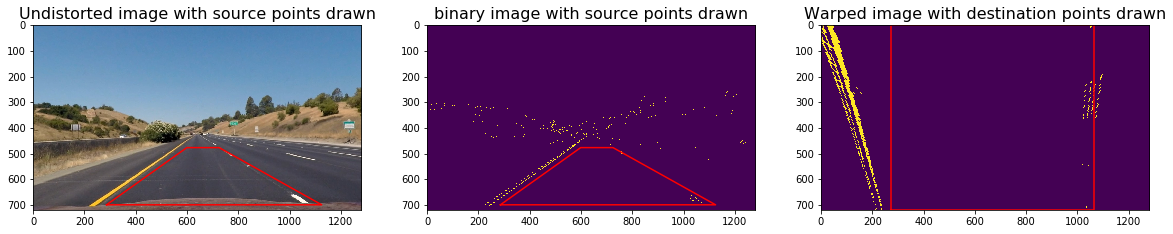

In [38]:
image = mpimg.imread('output_images/undist/test1.jpg')


gradx, grady, mag, gradir, r_binary, s_binary, r_binary, combined_binary = process_images(image)

warped, M, src, dst, MinV = per_transform(combined_binary)

#plt_images(undist, 'Undistorted Source Image', warped, 'perspective transform')
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.set_title('Undistorted image with source points drawn', fontsize=16)
ax1.plot(Polygon(src).get_xy()[:, 0], Polygon(src).get_xy()[:, 1], color='red')
ax1.imshow(image)

ax2.set_title('binary image with source points drawn', fontsize=16)
ax2.plot(Polygon(src).get_xy()[:, 0], Polygon(src).get_xy()[:, 1], color='red')
ax2.imshow(combined_binary)

ax3.set_title('Warped image with destination points drawn', fontsize=16)
ax3.plot(Polygon(dst).get_xy()[:, 0], Polygon(dst).get_xy()[:, 1], color='red')
ax3.imshow(warped)
plt.savefig('output_images/per_transform_imgs/per_tra_stg1_out.jpg')

<function matplotlib.pyplot.close(fig=None)>

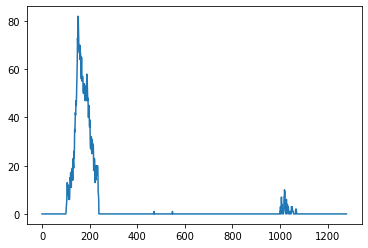

In [39]:
his_img, left_base, right_base = hist(warped)
plt.plot(his_img)
plt.savefig('output_images/histogram.jpg')
plt.close

True

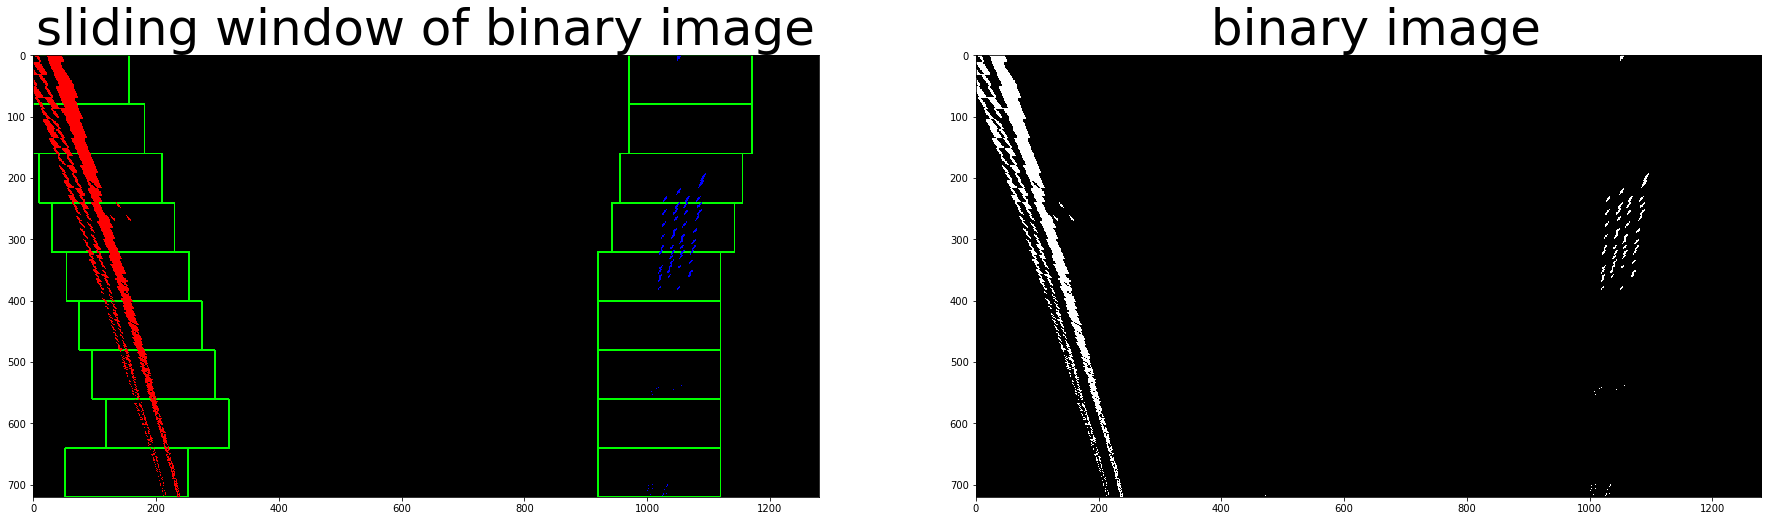

In [40]:
out_img, left_fit, right_fit, left_fitx, ploty, right_fitx, ploty = fit_polynomial(warped)
plt_images(out_img, 'sliding window of binary image', warped, ' binary image')
cv2.imwrite('output_images/sliding_window.jpg', out_img)

True

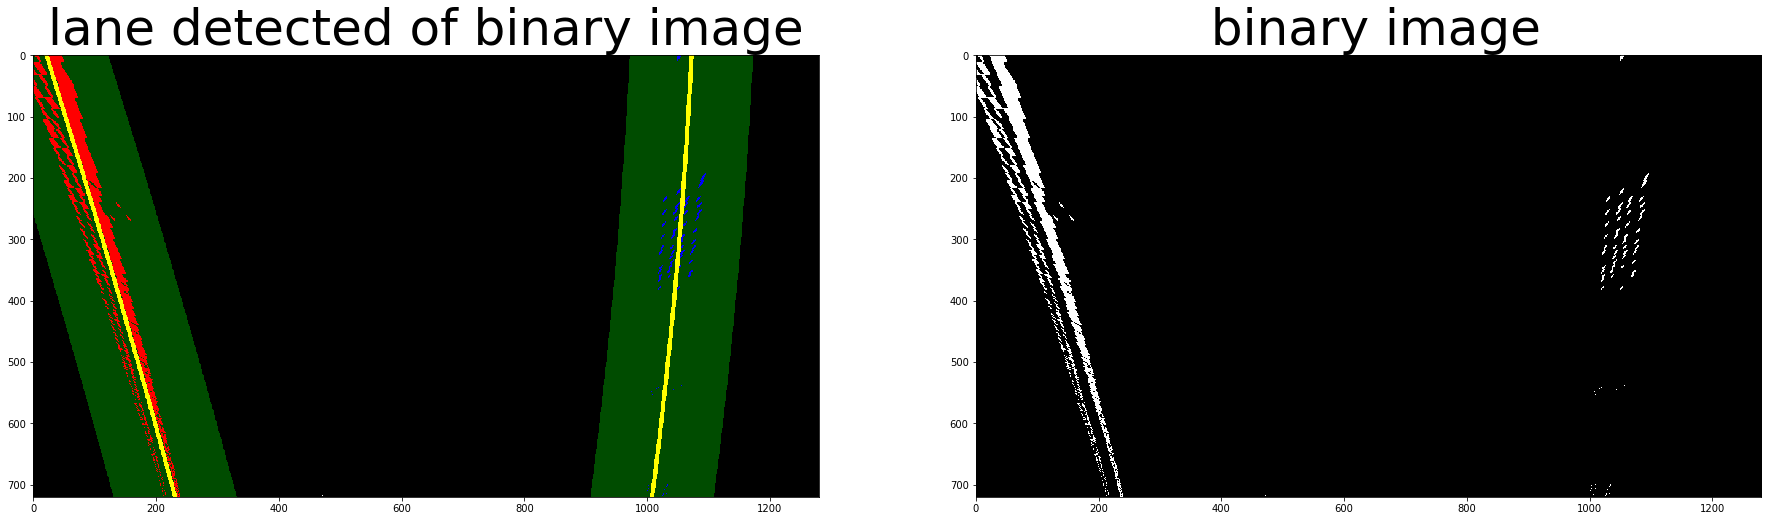

In [41]:
(left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty), out = detect_similar_lines(warped,left_fit, right_fit)
plt_images(out, 'lane detected of binary image', warped, ' binary image', cmap ='gray')
cv2.imwrite('output_images/lane_detected.jpg', out)

In [42]:
left_cuv, right_cuv = curvature_radius (left_fitx, right_fitx, warped, xm_per_pix=3.7/700, ym_per_pix = 30/720)

In [43]:
VehPos = car_pos(warped, left_fitx, right_fitx, xm_per_pix=3.7/700)

True

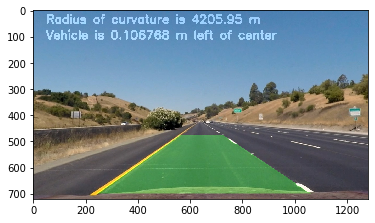

In [44]:
lane_img = lane(image, warped, left_fitx, right_fitx, ploty, MinV, left_cuv, right_cuv, VehPos)
plt.imshow(lane_img)
cv2.imwrite('output_images/lane_image.jpg', cv2.cvtColor(lane_img, cv2.COLOR_RGB2BGR))

In [45]:
def process_pipeline(img):
    
    img_size = (img.shape[1], img.shape[0])
    #calibrate camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    
    #remove the distortion from the image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    # apply, gradient, magnitude and color thresholds
    gradx, grady, mag, gradir, r_binary, s_binary, r_binary, combined_binary = process_images(undist) 
    
    #apply perspective transform
    warped, M, src, dst, MinV = per_transform(combined_binary)    

    #fit polynomial to find the area of interst
    out_img, left_fit, right_fit, left_fitx, ploty, right_fitx, ploty = fit_polynomial(warped)
    
    #detect the lane pixels
    (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty), out = detect_similar_lines(warped,left_fit, right_fit)
    
    #find the curvature
    left_cuv, right_cuv = curvature_radius (left_fitx, right_fitx, warped, xm_per_pix=3.7/700, ym_per_pix = 30/700)
    
    #find the vehicle position
    VehPos = car_pos(warped, left_fitx, right_fitx, xm_per_pix=3.7/700)
    
    #fill the lane with all the above calculated information
    result_lane = lane(img, warped, left_fitx, right_fitx, ploty, MinV, left_cuv, right_cuv, VehPos)

    return result_lane

In [63]:
output = 'output_videos/project_video_solution.mp4'

clip1 = VideoFileClip('project_video.mp4').subclip(0,20)

white_clip = clip1.fl_image(process_pipeline) 
%time white_clip.write_videofile(output, audio=False)

Moviepy - Building video output_videos/project_video_solution.mp4.
Moviepy - Writing video output_videos/project_video_solution.mp4



Moviepy - Done !
Moviepy - video ready output_videos/project_video_solution.mp4
Wall time: 12min 36s


In [64]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(output))